In [ ]:
# Plotting violins

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_true_vs_pred_and_violin(file_path, unique_labels, ax=None, expand_lims=False):
    # Load the npz file
    npz_file = np.load(file_path)
    if ax is None:
        ax = plt.gca()
    
    # Extract necessary data
    true_labels = npz_file['true_labels']
    if 'pred_values' in npz_file:
        pred_values = npz_file['pred_values']
    else:
        pred_values = npz_file['pred_labels']
    
    # Unique true labels (28, 100, 148)
    
    # Group pred_values based on true_labels
    grouped_pred_values = [pred_values[true_labels == label] for label in unique_labels]

    # Check if the grouping is correct and print basic statistics
    for label, group in zip(unique_labels, grouped_pred_values):
        print(f"True Label {label} - Group Size: {len(group)} - Predicted Values Range: {np.min(group)} to {np.max(group)}")
        if len(group) == 0:
            print(f"Warning: No predicted values found for True Label {label}")
    
    # Plot the violins
    violin_parts = ax.violinplot(
        grouped_pred_values, 
        positions=unique_labels,  # Custom x-axis positions
        widths=10 if expand_lims else 30,              # Increased width of violins
        showmeans=False,           # Do not show the mean
        showmedians=False,         # Do not show the median
        showextrema=False,         # Remove the vertical extrema (min/max) lines
        bw_method='silverman',    # Bandwidth method for smoothing
        points=200,               # Number of points for KDE estimation
        side='both'               # Plot both sides of the violin
    )
    
    # Customize the appearance
    ax.set_xticks(unique_labels, [str(_) for _ in unique_labels])  # Label x-axis with unique true labels
    ax.set_xlabel('Time (hrs)', fontsize='xx-large')
    ax.set_ylabel('Predicted time (hrs)', fontsize='xx-large')
    ax.tick_params('both', labelsize='x-large')

    # Customize colors and styles for each component of the violins
    for vp in violin_parts['bodies']:
        vp.set_facecolor('grey')   # Set face color to grey
        vp.set_edgecolor('none')  # Set edge color to none
        vp.set_linewidth(1.5)      # Thicker lines for clarity

    if expand_lims:

        # Get maximum limit for both axes
        x_min = min(unique_labels) - 20
        y_min = min(unique_labels) - 20
        x_max = max(unique_labels) + 20
        y_max = max(unique_labels) + 20
    else:
        
        # Get maximum limit for both axes
        x_min = 0
        y_min = 0
        x_max = max(unique_labels) + 20
        y_max = max(unique_labels) + 20
    
    # Add a grey line for y = x (diagonal line) from origin to the maximum limit
    ax.plot([x_min, x_max], [x_min, y_max], 
             color='k', linestyle='--', linewidth=1, label="y = x")
    # Set the axis limits to include the origin and add some padding
    ax.set_xlim(x_min, x_max)  
    ax.set_ylim(y_min, y_max)  

    
# # Create the violin plot without jittering
# plt.figure(figsize=(7, 5.5))
# # Provide the file path
# file_path = "/pscratch/sd/n/niranjan/output/prediction_10_14_01_00.npz"
# plot_true_vs_pred_and_violin(file_path, [28, 100, 148])

# # Save the figure to a file
# plt.savefig("ambr01_violin.png", dpi=100)


True Label 28 - Group Size: 38000 - Predicted Values Range: 18.39816665649414 to 151.71939086914062
True Label 100 - Group Size: 38000 - Predicted Values Range: 22.286834716796875 to 155.50765991210938
True Label 148 - Group Size: 38000 - Predicted Values Range: 24.64922332763672 to 173.28944396972656
True Label 52 - Group Size: 57000 - Predicted Values Range: 45.641658782958984 to 183.84339904785156
True Label 141 - Group Size: 57000 - Predicted Values Range: 46.380672454833984 to 197.47816467285156
True Label 189 - Group Size: 57000 - Predicted Values Range: 55.572669982910156 to 203.16896057128906
True Label 0 - Group Size: 28500 - Predicted Values Range: -15.530405044555664 to 119.3656234741211
True Label 31 - Group Size: 28500 - Predicted Values Range: -2.8419606685638428 to 111.99339294433594
True Label 55 - Group Size: 28500 - Predicted Values Range: -0.4750335216522217 to 110.93650817871094
True Label 79 - Group Size: 28500 - Predicted Values Range: -3.8244898319244385 to 127.5

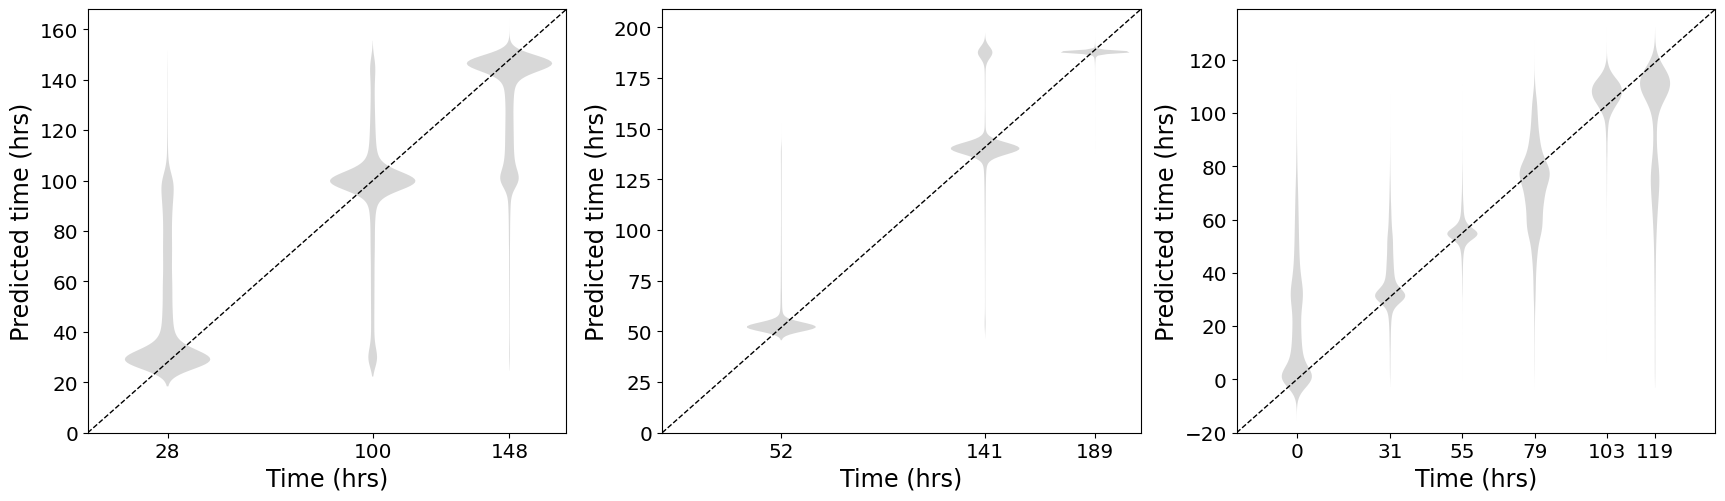

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5.5))
axes = axes.flatten()

file_path = "/pscratch/sd/n/niranjan/output/prediction_10_14_01_00.npz"
plot_true_vs_pred_and_violin(file_path, [28, 100, 148], ax=axes[0])

file_path = "/pscratch/sd/n/niranjan/output/ambr03/prediction_10_15_03_00.npz"
plot_true_vs_pred_and_violin(file_path, [52, 141, 189], ax=axes[1])

file_path = "/pscratch/sd/n/niranjan/output/prediction_10_15_00_00.npz"
plot_true_vs_pred_and_violin(file_path, [0, 31, 55, 79, 103, 119], expand_lims=True, ax=axes[2])

plt.savefig("violin_plots.png", dpi=100)
# ambr01 condiitoons violin plot

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import os

def plot_confusion_matrix_subplot(npz_file_path, custom_labels, ax):
    # Load the NPZ file
    data = np.load(npz_file_path, allow_pickle=True)

    # Extract true labels
    true_labels = data['true_labels']  
    
    # Check if the file contains 'pred_labels' or 'pred_values'
    if 'pred_labels' in data:
        pred_labels = data['pred_labels']
    elif 'pred_values' in data:
        pred_labels = data['pred_values']
    else:
        raise KeyError("The file does not contain 'pred_labels' or 'pred_values'.")

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Normalize the confusion matrix to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot confusion matrix using seaborn heatmap with a greyscale color map
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Greys",
                xticklabels=custom_labels, yticklabels=custom_labels, ax=ax, square=True)

    # Add labels and title
    ax.set_ylabel('True Labels', fontsize=12)
    ax.set_xlabel('Predicted Labels', fontsize=12)
   

    # Adjust label rotations: Predicted (x-axis) horizontal, True (y-axis) vertical
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(custom_labels, rotation=0)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(custom_labels, rotation=0)



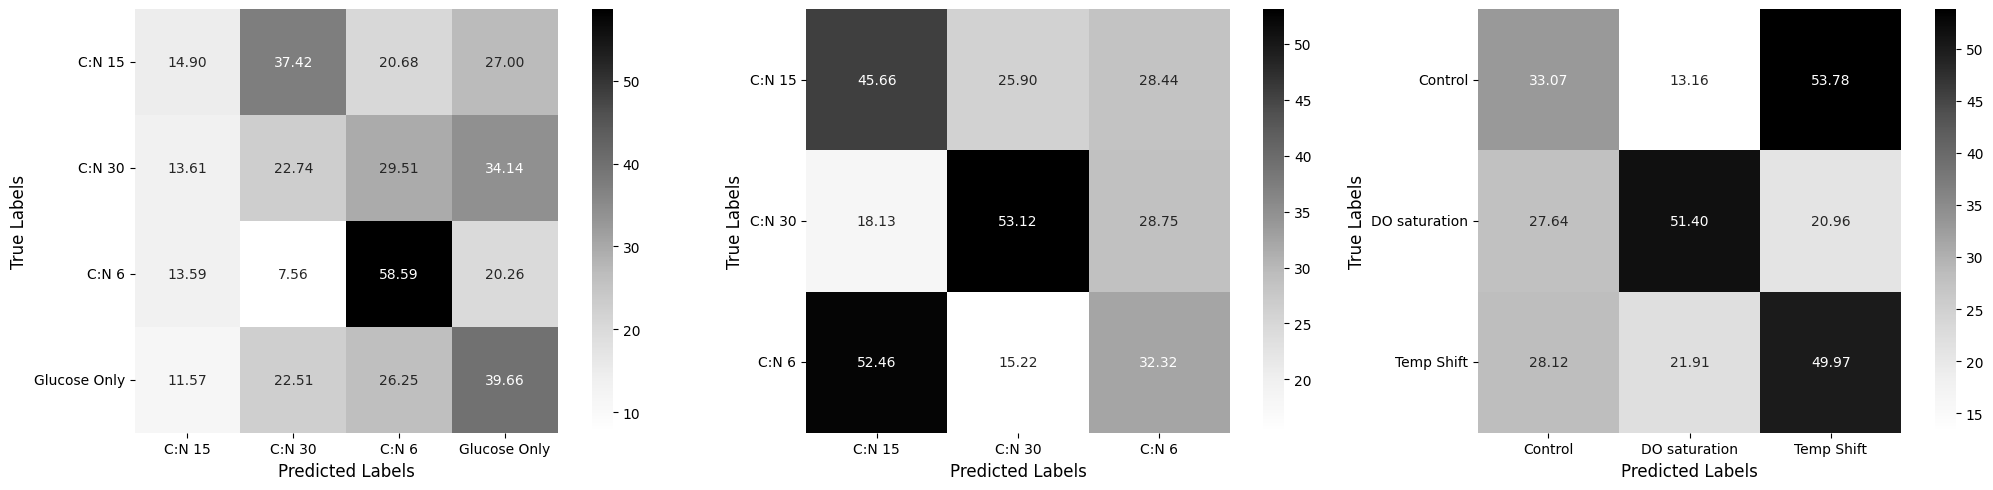

In [31]:
def plot_combined_confusion_matrices():
    # Paths to NPZ files and corresponding labels and titles
    npz_files = [
        ("/pscratch/sd/n/niranjan/output/prediction_10_18_01_00.npz", ['C:N 15', 'C:N 30', 'C:N 6', 'Glucose Only']),
        ("/pscratch/sd/n/niranjan/output/ambr03/prediction_10_18_03_00.npz", ['C:N 15', 'C:N 30', 'C:N 6']),
        ("/pscratch/sd/n/niranjan/output/prediction_10_18_00_00.npz", ['Control', 'DO saturation', 'Temp Shift'])
    ]

    # Create subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(26, 5.5))
    axes = axes.flatten()

    # Iterate through each NPZ file and custom labels to plot confusion matrices
    for i, (npz_file_path, custom_labels) in enumerate(npz_files):
        plot_confusion_matrix_subplot(npz_file_path, custom_labels, axes[i])
    plt.subplots_adjust(wspace=0) 

# Call the function to plot combined confusion matrices
plot_combined_confusion_matrices()
plt.savefig("conf_matrices.png", dpi=300)

In [3]:
import numpy as np
from sklearn.metrics import r2_score

# List of file paths to analyze
file_paths = [
    "/pscratch/sd/n/niranjan/output/prediction_10_15_00_00.npz",
    "/pscratch/sd/n/niranjan/output/ambr03/prediction_10_15_03_00.npz",
    "/pscratch/sd/n/niranjan/output/prediction_10_14_01_00.npz"
]

# Loop through each file and compute the R² score
for file_path in file_paths:
    npz_file = np.load(file_path)
    
    # Extract true and predicted values
    true_labels = npz_file['true_labels']
    
    # Check for 'pred_values' or 'pred_labels' and set pred_values accordingly
    if 'pred_values' in npz_file:
        pred_values = npz_file['pred_values']
    else:
        pred_values = npz_file['pred_labels']
    
    # Compute the R² score
    r2 = r2_score(true_labels, pred_values)
    print(f"R² score for {file_path}: {r2:.4f}")


R² score for /pscratch/sd/n/niranjan/output/prediction_10_15_00_00.npz: 0.7101
R² score for /pscratch/sd/n/niranjan/output/ambr03/prediction_10_15_03_00.npz: 0.9021
R² score for /pscratch/sd/n/niranjan/output/prediction_10_14_01_00.npz: 0.6465
